Setting numpy spacing (you know were this come from)

In [22]:
import numpy as np
import kaggle
from pathlib import Path
np.set_printoptions(linewidth=130)

In [23]:
# get titanic dataset

import zipfile,kaggle
path = Path('titanic')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
import pandas as pd

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [26]:
# Compute statistics from training set
modes = df.mode().iloc[0]
fare_medians = df.groupby('Pclass')['Fare'].median()
age_medians = df.groupby(['Pclass', 'Sex'])['Age'].median()

In [27]:
# Define enhanced processing function
def proc_data(df):
    # Create new features
    df['CabinKnown'] = df['Cabin'].notna().astype(int)
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Fill missing values
    df['Fare'] = df['Fare'].fillna(df['Pclass'].map(fare_medians))
    df['Age'] = df['Age'].fillna(df.apply(
        lambda row: age_medians[row['Pclass'], row['Sex']] if pd.isna(row['Age']) else row['Age'], axis=1))
    df.fillna(modes, inplace=True)
    
    # Transformations
    df['LogFare'] = np.log1p(df['Fare'])
    
    # Convert to categorical
    df['Sex'] = pd.Categorical(df['Sex'])
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['Title'] = pd.Categorical(df['Title'])
    df['Pclass'] = pd.Categorical(df['Pclass'])
    df['IsAlone'] = pd.Categorical(df['IsAlone'])

proc_data(df)
proc_data(tst_df)

In [28]:
cats = ['Sex', 'Embarked', 'Title', 'Pclass', 'IsAlone']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'FamilySize', 'CabinKnown']
dep = 'Survived'

# Inspect the result
print(df[cats + conts + [dep]].head())

      Sex Embarked Title Pclass IsAlone   Age  SibSp  Parch   LogFare  \
0    male        S    Mr      3       0  22.0      1      0  2.110213   
1  female        C   Mrs      1       0  38.0      1      0  4.280593   
2  female        S  Miss      3       1  26.0      0      0  2.188856   
3  female        S   Mrs      1       0  35.0      1      0  3.990834   
4    male        S    Mr      3       1  35.0      0      0  2.202765   

   FamilySize  CabinKnown  Survived  
0           2           0         0  
1           2           1         1  
2           1           0         1  
3           2           1         1  
4           1           0         0  


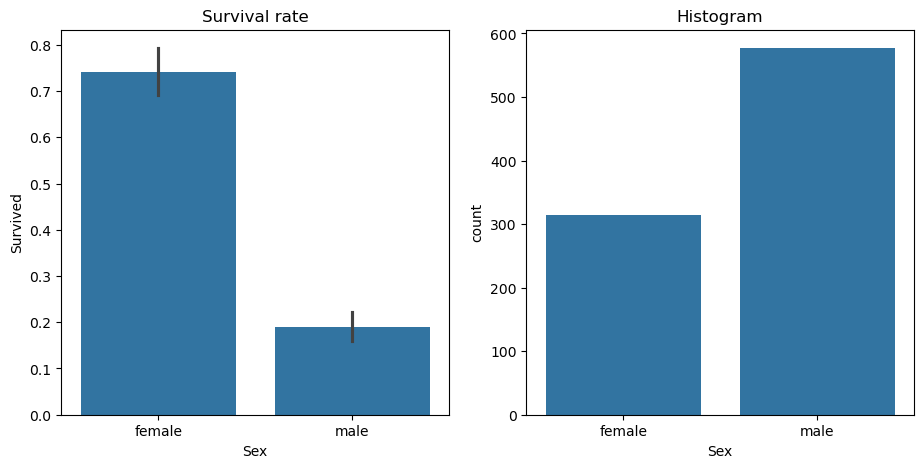

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [30]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.2)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

trn_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsAlone,LogFare
331,332,0,0,"Partner, Mr. Austen",1,45.5,0,0,113043,28.5000,C124,2,1,12,1,1,3.384390
733,734,0,1,"Berriman, Mr. William John",1,23.0,0,0,28425,13.0000,B96 B98,2,0,12,1,1,2.639057
382,383,0,2,"Tikkanen, Mr. Juho",1,32.0,0,0,STON/O 2. 3101293,7.9250,B96 B98,2,0,12,1,1,2.188856
704,705,0,2,"Hansen, Mr. Henrik Juul",1,26.0,1,0,350025,7.8542,B96 B98,2,0,12,2,0,2.180892
813,814,0,2,"Andersson, Miss. Ebba Iris Alfrida",0,6.0,4,2,347082,31.2750,B96 B98,2,0,9,7,0,3.474293


In [31]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [32]:
preds = val_xs.Sex==0

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21787709497206703

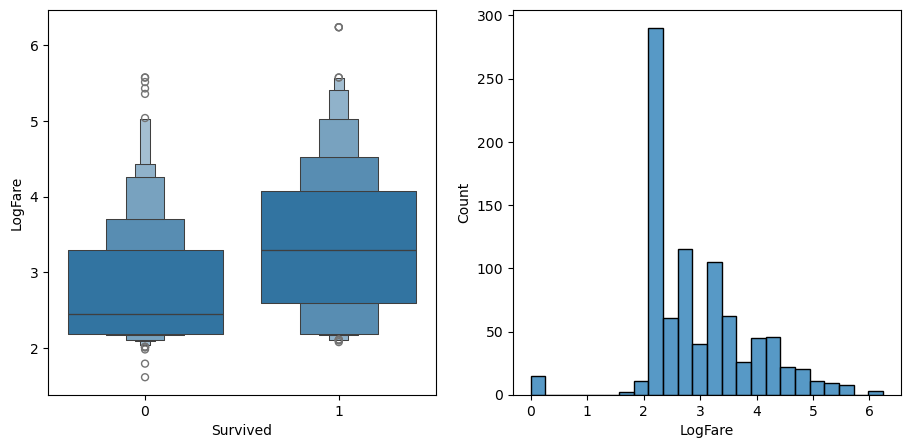

In [34]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.histplot(data=df, x="LogFare", ax=axs[1])
plt.show()

In [35]:
def gini(df, dep='Survived'):
    p = df[dep].mean()
    return 1 - p**2 - (1 - p)**2

In [36]:
gini(trn_df)

0.4694483019820728

In [37]:
def score(df, cond, dep='Survived'):
    parent_gini = gini(df, dep)
    
    lhs = df[cond]
    rhs = df[~cond]
    
    return parent_gini - gini(lhs, dep) * len(lhs)/len(df) - gini(rhs, dep) * len(rhs)/len(df)

In [38]:
score(df, df.Sex=='male') 

0.13964795747285233

In [39]:
score(df, df.LogFare < 2.7)

0.03201654347053301

In [40]:
conds = ['<', '=']

def iscore(nm, split, cnd):
    if cnd == '<':
        return score(trn_df, trn_df[nm] > split)
    else:
        return score(trn_df, trn_df[nm] == split)

from ipywidgets import interact
interact(nm=conts+cats, split=15.5, cnd=conds)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'FamilySize', 'C…

In [41]:
nm = "Age"
col = trn_df[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 21.5 , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  ,
       27.  , 28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  ,
       40.  , 40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  ,
       55.  , 55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [42]:
scores = np.array([score(df, df[nm] > threshold) for threshold in unq if not np.isnan(threshold)])
scores = np.nan_to_num(scores, nan=0.0)
unq[scores.argmax()]

6.0

In [43]:
def max_in_gain(df, nm):
    col = df[nm]
    unq = col.dropna().unique()
    scores = np.array([score(df, df[nm] <= o) for o in unq if not np.isnan(o)])
    scores = np.nan_to_num(scores, nan=0.0)
    idx = scores.argmax()
    return unq[idx],scores[idx]

max_in_gain(df, "Age")

(6.0, 0.01128312550541316)

In [44]:
cols = cats+conts
{o:max_in_gain(trn_df, o) for o in cols}

{'Sex': (0, 0.13777997649438187),
 'Embarked': (0, 0.011962629260368396),
 'Title': (12, 0.05835211917297576),
 'Pclass': (1, 0.04633689581360795),
 'IsAlone': (0, 0.01530191370299705),
 'Age': (5.0, 0.011566117051788616),
 'SibSp': (3, 0.0059358222809473525),
 'Parch': (0, 0.009205311139441064),
 'LogFare': (2.4390808375825834, 0.03861217211191381),
 'FamilySize': (1, 0.01530191370299705),
 'CabinKnown': (0, 0.04235486147096447)}

MMMM according to this the largest information gain is achieved by sex, let's see if we calculate the gain using cross-entropy instead of Gini

In [45]:
def cross_entropy(df, dep='Survived'):
    p = df[dep].mean()
    if p == 0 or p == 1:
        return 0  # to avoid log(0) issues; entropy is 0 when pure
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

In [46]:
def ce_score(df, cond, dep='Survived'):
    parent_ce = cross_entropy(df, dep)
    
    lhs = df[cond]
    rhs = df[~cond]
    
    return parent_ce - cross_entropy(lhs, dep) * len(lhs)/len(df) - cross_entropy(rhs, dep) * len(rhs)/len(df)

In [47]:
def max_in_gain_ce(df, nm):
    col = df[nm]
    unq = col.dropna().unique()
    scores = np.array([ce_score(df, df[nm] <= o) for o in unq if not np.isnan(o)])
    scores = np.nan_to_num(scores, nan=0.0)
    idx = scores.argmax()
    return unq[idx],scores[idx]

max_in_gain_ce(df, "Age")

(6.0, 0.011578722768531668)

In [48]:
cols = cats+conts
{o:max_in_gain_ce(trn_df, o) for o in cols}

{'Sex': (0, 0.1492870700344417),
 'Embarked': (0, 0.01238250808610497),
 'Title': (12, 0.06141118175627637),
 'Pclass': (1, 0.04978432383360609),
 'IsAlone': (0, 0.01621211811964257),
 'Age': (5.0, 0.011881651194982856),
 'SibSp': (4, 0.008046329770353022),
 'Parch': (0, 0.009610333976850266),
 'LogFare': (2.4390808375825834, 0.043145685874994955),
 'FamilySize': (1, 0.01621211811964257),
 'CabinKnown': (0, 0.04401681021051718)}

In [49]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [50]:
{o:max_in_gain_ce(males, o) for o in cols}

{'Embarked': (0, 0.007312842174070966),
 'Title': (8, 0.02805975622713569),
 'Pclass': (0, 0.01820000312353115),
 'IsAlone': (0, 0.006781257875705715),
 'Age': (6.0, 0.02955359013495068),
 'SibSp': (2, 0.004308924141516346),
 'Parch': (0, 0.007092979810789185),
 'LogFare': (3.305053521109253, 0.01888673922233519),
 'FamilySize': (1, 0.006781257875705715),
 'CabinKnown': (0, 0.031229581076443677)}

In [51]:
{o:max_in_gain(males, o) for o in cols}

{'Embarked': (0, 0.004906974135611308),
 'Title': (8, 0.021467785077321527),
 'Pclass': (0, 0.012382352046451606),
 'IsAlone': (0, 0.004297912282940547),
 'Age': (6.0, 0.024278381799043514),
 'SibSp': (0, 0.0025127696155566315),
 'Parch': (0, 0.0047276466150457525),
 'LogFare': (3.305053521109253, 0.01236734578559559),
 'FamilySize': (1, 0.004297912282940533),
 'CabinKnown': (0, 0.021985396693622122)}

In [52]:
{o:max_in_gain_ce(females, o) for o in cols}

{'Embarked': (0, 0.016872459262018524),
 'Title': (9, 0.01911434463924072),
 'Pclass': (1, 0.16263640353015985),
 'IsAlone': (0, 0.003886258872752707),
 'Age': (21.5, 0.028495758626381373),
 'SibSp': (2, 0.0333962543573451),
 'Parch': (3, 0.028004538109382193),
 'LogFare': (3.8691155044168695, 0.042930677976993736),
 'FamilySize': (4, 0.06375610199748942),
 'CabinKnown': (0, 0.04849974935777902)}

In [53]:
{o:max_in_gain(females, o) for o in cols}

{'Embarked': (0, 0.011461160480329968),
 'Title': (9, 0.01413296184061237),
 'Pclass': (1, 0.11219188214498144),
 'IsAlone': (0, 0.0029583267587040274),
 'Age': (21.5, 0.02233304619406634),
 'SibSp': (2, 0.03008342083827442),
 'Parch': (3, 0.022741218936554175),
 'LogFare': (3.8691155044168695, 0.02793763742489827),
 'FamilySize': (4, 0.05695658296187893),
 'CabinKnown': (0, 0.03153037142456433)}

In [54]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [57]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

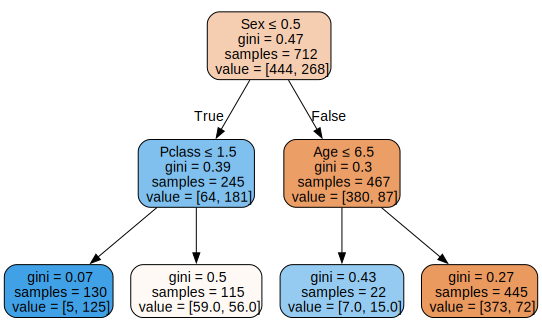

In [58]:
draw_tree(m, trn_xs, size=10)

In [59]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2346368715083799

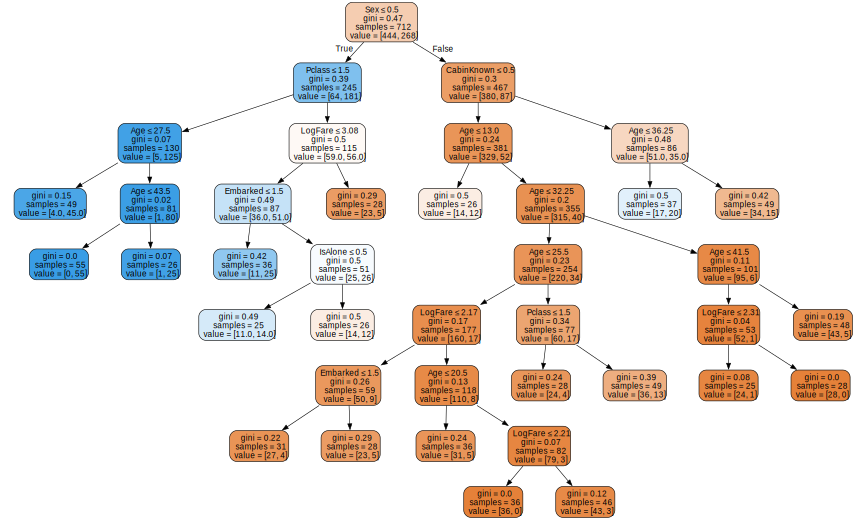

In [60]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [61]:
mean_absolute_error(val_y, m.predict(val_xs))


0.18435754189944134

In [62]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [83]:
def get_tree(prop=0.80):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=10).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [86]:
trees = [get_tree() for t in range(25)]

In [87]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2158659217877095

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(25, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.16759776536312848

In [99]:
subm(rf.predict(tst_xs), 'rf')

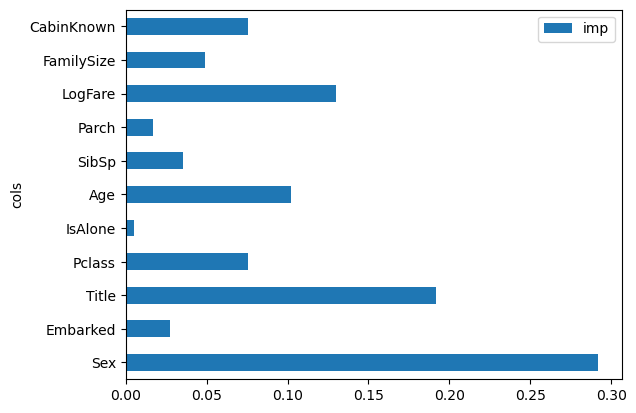

In [103]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');